# I have the following hypothesis:

* In the mid to late 1980's, there was a big push to put a warning label on records and CD's that were deemed 'explicit' and had suggestive or 'satanic' lyrics. This was supposed to help parents monitor the music their children were buying. I propose it had the opposite effect. Albums and music with explicit lyrics and images were more popular after the mid to late 1980's.

I will test this hypothesis by creating different groups of data separated by genre, explicit vs non-explicit, and a combination of both. I will also separate out the 'Top 10' songs, so that I can test the popularity of songs. The graphs and statistical data will compare these groups before and after an arbritary date (sometime between 1985 and 1990). If songs and albums with explicit lyrics and images (rap, hip-hop, heavy metal, etc.) were more popular than non-explicit songs after a certain year, it would suggest my hypothesis is correct.

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import ast
from datetime import datetime

%matplotlib inline

<IPython.core.display.Javascript object>

# Read dataframes, drop duplicate genres

In [3]:
hot_100 = pd.read_csv("data/Hot_Stuff.csv")
spotify = pd.read_excel("data/Hot_100_Audio_Features.xlsx")

<IPython.core.display.Javascript object>

In [4]:
spotify["spotify_genre"].explode().value_counts()

[]                                                                                                                                                     2541
['contemporary country', 'country', 'country road']                                                                                                     315
['contemporary country', 'country', 'country road', 'modern country rock']                                                                              279
['dance pop', 'pop', 'post-teen pop']                                                                                                                   252
['glee club', 'hollywood', 'post-teen pop']                                                                                                             205
                                                                                                                                                       ... 
['alternative metal', 'alternative rock', 'dance-punk', 'garage 

<IPython.core.display.Javascript object>

In [5]:
spotify = spotify.drop_duplicates()

<IPython.core.display.Javascript object>

# Drop columns that are not needed

In [6]:
hot_100 = hot_100.drop(columns=["url"])

<IPython.core.display.Javascript object>

In [7]:
spotify = spotify.drop(
    columns=[
        "spotify_track_id",
        "spotify_track_preview_url",
        "spotify_track_duration_ms",
        "spotify_track_popularity",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "acousticness",
        "speechiness",
        "liveness",
        "instrumentalness",
        "valence",
        "tempo",
        "time_signature",
    ]
)

<IPython.core.display.Javascript object>

# Basic table description data

In [8]:
hot_100.shape

(320495, 9)

<IPython.core.display.Javascript object>

In [9]:
hot_100.isna().sum()

WeekID                        0
Week Position                 0
Song                          0
Performer                     0
SongID                        0
Instance                      0
Previous Week Position    30784
Peak Position                 0
Weeks on Chart                0
dtype: int64

<IPython.core.display.Javascript object>

In [10]:
hot_100.head()

,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1


<IPython.core.display.Javascript object>

In [11]:
hot_100.dtypes

WeekID                     object
Week Position               int64
Song                       object
Performer                  object
SongID                     object
Instance                    int64
Previous Week Position    float64
Peak Position               int64
Weeks on Chart              int64
dtype: object

<IPython.core.display.Javascript object>

In [12]:
spotify.shape

(28470, 6)

<IPython.core.display.Javascript object>

In [13]:
spotify.isna().mean()

SongID                    0.000000
Performer                 0.000000
Song                      0.000000
spotify_genre             0.043133
spotify_track_album       0.166737
spotify_track_explicit    0.166526
dtype: float64

<IPython.core.display.Javascript object>

In [14]:
spotify.head()

,SongID,Performer,Song,spotify_genre,spotify_track_album,spotify_track_explicit
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],Adicto (with Anuel AA & Ozuna),0.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",A Star Is Born Soundtrack,0.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",Hollywood's Bleeding,1.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",Bacc At It Again,1.0


<IPython.core.display.Javascript object>

In [15]:
spotify.dtypes

SongID                     object
Performer                  object
Song                       object
spotify_genre              object
spotify_track_album        object
spotify_track_explicit    float64
dtype: object

<IPython.core.display.Javascript object>

# Fill null values, convert previous week position to an integer

In [16]:
spotify["spotify_track_album"].fillna(" ", inplace=True)
hot_100["Previous Week Position"].fillna(int(0), inplace=True)

<IPython.core.display.Javascript object>

In [17]:
hot_100 = hot_100.astype({"Previous Week Position": int})

<IPython.core.display.Javascript object>

In [18]:
spotify["spotify_genre"].fillna("[]", inplace=True)
spotify["spotify_genre_list"] = spotify["spotify_genre"].apply(ast.literal_eval)

<IPython.core.display.Javascript object>

# Join the 2 tables by SongID (song and performer)

In [19]:
full_table = hot_100.merge(spotify, left_on="SongID", right_on="SongID")
full_table

,WeekID,Week Position,Song_x,Performer_x,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,Performer_y,Song_y,spotify_genre,spotify_track_album,spotify_track_explicit,spotify_genre_list
0,2/2/2019,1,7 Rings,Ariana Grande,7 RingsAriana Grande,1,0,1,1,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
1,5/25/2019,11,7 Rings,Ariana Grande,7 RingsAriana Grande,1,10,1,17,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
2,4/20/2019,4,7 Rings,Ariana Grande,7 RingsAriana Grande,1,3,1,12,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
3,6/1/2019,12,7 Rings,Ariana Grande,7 RingsAriana Grande,1,11,1,18,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
4,3/30/2019,1,7 Rings,Ariana Grande,7 RingsAriana Grande,1,1,1,9,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320602,8/25/1962,18,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,23,18,7,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"
320603,9/1/1962,12,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,18,12,8,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"
320604,9/8/1962,14,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,12,12,9,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"
320605,9/15/1962,31,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,14,12,10,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"


<IPython.core.display.Javascript object>

# Remove unnecessary columns, re-label columns

In [20]:
full_table = full_table.drop(columns=["Performer_y", "Song_y"])

<IPython.core.display.Javascript object>

In [21]:
full_table.rename(
    columns={
        "WeekID": "week",
        "Week Position": "week_pos",
        "Song_x": "song",
        "Performer_x": "artist",
        "SongID": "song_id",
        "Instance": "instance",
        "Previous Week Position": "prev_week_pos",
        "Peak Position": "peak_pos",
        "Weeks on Chart": "weeks_on_chart",
        "spotify_genre": "genre_str",
        "spotify_genre_list": "genre_list",
        "spotify_track_album": "album",
        "spotify_track_explicit": "explicit",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

# Format week to a date format

In [22]:
full_table["week"] = full_table["week"].apply(
    lambda x: datetime.strptime(x, "%m/%d/%Y")
)
full_table["week"] = pd.to_datetime(full_table["week"])

<IPython.core.display.Javascript object>

# Put month and year in new columns

In [23]:
full_table["year"], full_table["month"] = (
    full_table["week"].dt.year,
    full_table["week"].dt.month,
)

<IPython.core.display.Javascript object>

# Check explicit vs not explicit counts for reference

In [24]:
full_table["explicit"].value_counts()

0.0    249361
1.0     31060
Name: explicit, dtype: int64

<IPython.core.display.Javascript object>

# Create a table with means, only use songs in the top 75 to make the dataframe a little smaller.  This is the main table used in analysis.

In [25]:
top_song_limit = 75
top_songs = full_table[full_table["week_pos"] <= top_song_limit]
top_songs = top_songs.groupby(["song_id", "genre_str"]).mean()
top_songs = top_songs.reset_index()

<IPython.core.display.Javascript object>

In [26]:
top_songs["year"] = round(top_songs["year"])
top_songs["month"] = round(top_songs["month"])
top_songs

,song_id,genre_str,week_pos,instance,prev_week_pos,peak_pos,weeks_on_chart,explicit,year,month
0,"""B"" GirlsYoung And Restless",[],61.750000,1.0,62.125000,57.125000,6.5,0.0,1990.0,6.0
1,"""Cherry Cherry"" from Hot August NightNeil Diamond","['adult standards', 'brill building pop', 'fol...",43.888889,1.0,47.555556,41.666667,6.0,0.0,1973.0,4.0
2,"""Having A Party"" MedleyThe Ovations (Featuring...","['memphis soul', 'southern soul']",64.800000,1.0,68.200000,63.600000,7.0,NaN,1973.0,11.0
3,"""Joy"" Pt. IIsaac Hayes","['classic soul', 'disco', 'funk', 'jazz funk',...",42.222222,1.0,37.555556,40.888889,5.0,NaN,1974.0,4.0
4,"""Roots"" MedleyQuincy Jones","['adult standards', 'disco', 'funk', 'jazz fun...",62.000000,1.0,66.750000,62.000000,4.5,NaN,1977.0,4.0
...,...,...,...,...,...,...,...,...,...,...
21834,teachmeMusiq Soulchild,"['alternative r&b', 'dance pop', 'neo soul', '...",56.117647,1.0,57.117647,49.823529,12.0,0.0,2007.0,8.0
21835,whoa (mind in awe)XXXTENTACION,"['emo rap', 'miami hip hop']",37.000000,1.0,0.000000,37.000000,1.0,0.0,2018.0,12.0
21836,whoknowsMusiq,"['alternative r&b', 'dance pop', 'neo soul', '...",70.600000,1.0,56.200000,67.800000,3.0,0.0,2004.0,5.0
21837,www.memoryAlan Jackson,"['contemporary country', 'country', 'country r...",57.166667,1.0,51.583333,51.500000,6.5,NaN,2000.0,9.0


<IPython.core.display.Javascript object>

# Add a genre label column.  Evaluate all of the genres in the list, and make a single genre decision.  Because there are lots of songs with a 'pop' genre, I override those with the other genres.

In [27]:
genre_list = ["rap", "hip hop", "metal", "country", "pop"]

<IPython.core.display.Javascript object>

In [28]:
for genre in genre_list:
    top_songs[genre] = top_songs["genre_str"].str.contains(fr"\b{genre}\b")

<IPython.core.display.Javascript object>

In [29]:
top_songs.loc[top_songs["pop"], "genre_label"] = "pop"
top_songs.loc[top_songs["rap"] | top_songs["hip hop"], "genre_label"] = "rap_hiphop"
top_songs.loc[top_songs["metal"], "genre_label"] = "metal"
top_songs.loc[top_songs["country"], "genre_label"] = "country"

top_songs["genre_label"].value_counts()

pop           7164
rap_hiphop    2836
country       2578
metal          671
Name: genre_label, dtype: int64

<IPython.core.display.Javascript object>

# Split the top songs by genre.  These violin plots are interesting because they show:

* There were very few 'explicit' songs before 1990
* Rap and hip-hop became popular right after the PMRC was formed in 1985
* Rap has many more explicit songs than not explicit songs

In [30]:
pop = top_songs[top_songs["genre_label"] == "pop"]
rap_hiphop = top_songs[top_songs["genre_label"] == "rap_hiphop"]
country = top_songs[top_songs["genre_label"] == "country"]
metal = top_songs[top_songs["genre_label"] == "metal"]

<IPython.core.display.Javascript object>

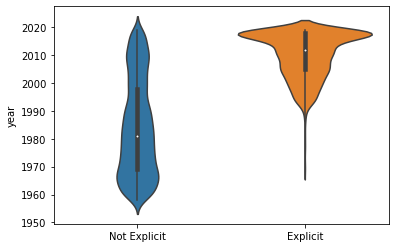

<IPython.core.display.Javascript object>

In [31]:
ax = sns.violinplot(x="explicit", y="year", data=top_songs)
ax.set_xticklabels(["Not Explicit", "Explicit"])
ax.set_xlabel("")
plt.savefig("violin_expl.png")
plt.show()

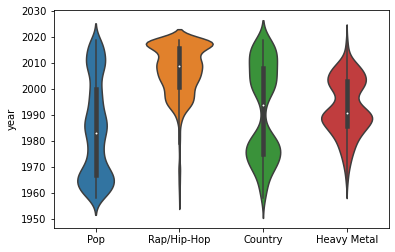

<IPython.core.display.Javascript object>

In [32]:
ax = sns.violinplot(x="genre_label", y="year", data=top_songs)
ax.set_xticklabels(["Pop", "Rap/Hip-Hop", "Country", "Heavy Metal"])
ax.set_xlabel("")
plt.savefig("violin_genre.png")
plt.show()

C:\Users\Steve\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Steve\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[]

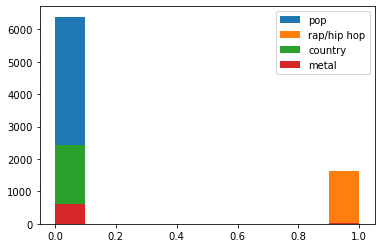

<IPython.core.display.Javascript object>

In [33]:
plt.hist(pop["explicit"], label="pop")
plt.hist(rap_hiphop["explicit"], label="rap/hip hop")
plt.hist(country["explicit"], label="country")
plt.hist(metal["explicit"], label="metal")
plt.legend()
plt.plot()

## ANOVA Assumption Check - Popularity by genre 
### The week position is the mean of all the weekly Hot 100 positions of each song.

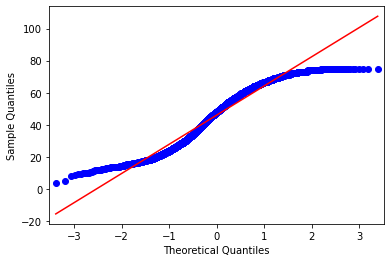

<IPython.core.display.Javascript object>

In [34]:
qqplot(rap_hiphop["week_pos"], line="s")
plt.show()

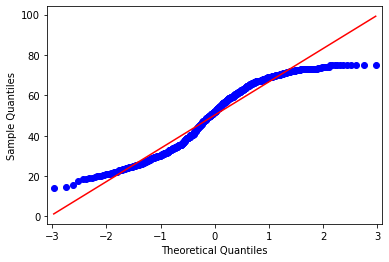

<IPython.core.display.Javascript object>

In [35]:
qqplot(metal["week_pos"], line="s")
plt.show()

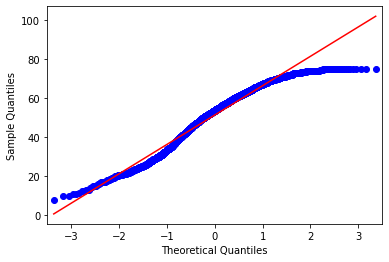

<IPython.core.display.Javascript object>

In [36]:
qqplot(country["week_pos"], line="s")
plt.show()

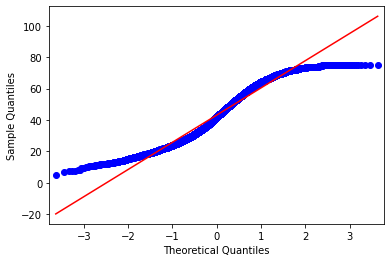

<IPython.core.display.Javascript object>

In [37]:
qqplot(pop["week_pos"], line="s")
plt.show()

# These plots show the data is not normalized, so I will perform the non-perimetric tests


## Kruskal Wallis test - Popularity by genre

[]

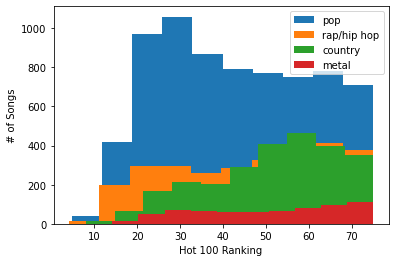

<IPython.core.display.Javascript object>

In [38]:
plt.hist(pop["week_pos"], label="pop")
plt.hist(rap_hiphop["week_pos"], label="rap/hip hop")
plt.hist(country["week_pos"], label="country")
plt.hist(metal["week_pos"], label="metal")
plt.xlabel("Hot 100 Ranking")
plt.ylabel("# of Songs")
plt.legend()
plt.savefig("hist_genre.png")
plt.plot()

# This plot further shows the data is not normalized, so I will perform the non-perimetric tests

In [39]:
_, p = stats.kruskal(
    pop["week_pos"], rap_hiphop["week_pos"], country["week_pos"], metal["week_pos"]
)
p

1.753006111660896e-102

<IPython.core.display.Javascript object>

## At least one median between the is genres is different

In [40]:
_, p1 = stats.mannwhitneyu(pop["week_pos"], rap_hiphop["week_pos"])
_, p2 = stats.mannwhitneyu(pop["week_pos"], country["week_pos"])
_, p3 = stats.mannwhitneyu(pop["week_pos"], metal["week_pos"])
_, p4 = stats.mannwhitneyu(rap_hiphop["week_pos"], country["week_pos"])
_, p5 = stats.mannwhitneyu(rap_hiphop["week_pos"], metal["week_pos"])
_, p6 = stats.mannwhitneyu(country["week_pos"], metal["week_pos"])


p_values = [p1, p2, p3, p4, p5, p6]
reject, corr_p, sidak, bonf = multipletests(p_values, alpha=0.05)

<IPython.core.display.Javascript object>

In [41]:
reject

array([ True,  True,  True,  True,  True, False])

<IPython.core.display.Javascript object>

In [42]:
corr_p

array([4.82947016e-14, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.29012820e-07, 1.26633124e-01])

<IPython.core.display.Javascript object>

In [43]:
sidak

0.008512444610847103

<IPython.core.display.Javascript object>

In [44]:
bonf

0.008333333333333333

<IPython.core.display.Javascript object>

## Based on our analysis we found:

* The mean rank of at least one of our samples is significantly different than the others
* There is a significant difference in mean rank between the popularity of pop and rap/hip-hop
* There is a significant difference in mean rank between the popularity of rap/hip-hop and metal

## ANOVA Assumption Check - Explicit vs not explicit by year

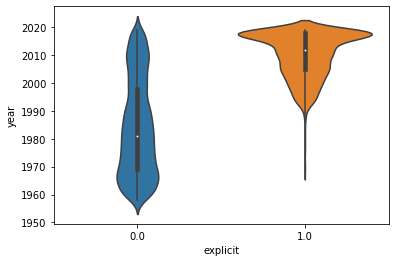

<IPython.core.display.Javascript object>

In [45]:
sns.violinplot(x="explicit", y="year", data=top_songs)
plt.show()

In [46]:
top_songs["explicit"].value_counts()

0.0    16776
1.0     1920
Name: explicit, dtype: int64

<IPython.core.display.Javascript object>

### I added rap and hip-hop to the tests because it became popular right after the PMRC was formed in 1985

In [47]:
top_expl = top_songs[top_songs["explicit"] == 1]
top_not_expl = top_songs[top_songs["explicit"] == 0]

rap_hiphop_expl = rap_hiphop[rap_hiphop["explicit"] == 1]
rap_hiphop_not_expl = rap_hiphop[rap_hiphop["explicit"] == 0]

<IPython.core.display.Javascript object>

In [48]:
top_expl.sort_values("year").head()

,song_id,genre_str,week_pos,instance,prev_week_pos,peak_pos,weeks_on_chart,explicit,year,month,rap,hip hop,metal,country,pop,genre_label
9256,In A MomentThe Intrigues,[],45.272727,1.0,48.363636,42.818182,9.0,1.0,1969.0,9.0,False,False,False,False,False,NaN
19589,Uncle John's BandThe Grateful Dead,['plunder'],71.000000,1.0,73.500000,71.000000,5.5,1.0,1970.0,9.0,False,False,False,False,False,NaN
9931,Jungle LoveThe Steve Miller Band,[],39.666667,1.0,40.583333,32.250000,7.5,1.0,1977.0,9.0,False,False,False,False,False,NaN
9215,If You're Not Back In Love By MondayMillie Jac...,"['classic soul', 'motown', 'quiet storm', 'sou...",50.666667,1.0,52.444444,48.444444,7.0,1.0,1977.0,7.0,False,False,False,False,False,NaN
12075,Midnight RendezvousThe Babys,"['album rock', 'classic rock', 'hard rock', 'm...",72.000000,1.0,76.000000,72.000000,3.0,1.0,1980.0,5.0,False,False,False,False,False,NaN


<IPython.core.display.Javascript object>

In [49]:
top_not_expl.sort_values("year").head()

,song_id,genre_str,week_pos,instance,prev_week_pos,peak_pos,weeks_on_chart,explicit,year,month,rap,hip hop,metal,country,pop,genre_label
10961,Little StarThe Elegants,"['doo-wop', 'rhythm and blues']",10.066667,1.0,7.400000,3.066667,8.0,0.0,1958.0,9.0,False,False,False,False,False,NaN
11540,Love You Most Of AllSam Cooke,"['adult standards', 'brill building pop', 'cla...",44.071429,1.0,40.928571,39.000000,7.5,0.0,1958.0,6.0,False,False,False,False,True,pop
11443,Love Of My LifeThe Everly Brothers,"['adult standards', 'brill building pop', 'bub...",53.666667,1.0,68.666667,45.333333,3.0,0.0,1958.0,12.0,False,False,False,False,True,pop
3232,Come Closer To Me (Acercate Mas)Nat King Cole,['adult standards'],51.666667,1.0,43.777778,44.555556,5.0,0.0,1958.0,8.0,False,False,False,False,False,NaN
11351,Love Is All We NeedTommy Edwards,"['deep adult standards', 'doo-wop']",32.428571,1.0,34.500000,23.071429,8.5,0.0,1958.0,8.0,False,False,False,False,False,NaN


<IPython.core.display.Javascript object>

# I'm only analyzing explicit songs after 1985 because there were so few of them before 1985

In [50]:
top_expl = top_expl[top_expl["year"] > 1985]
top_expl

,song_id,genre_str,week_pos,instance,prev_week_pos,peak_pos,weeks_on_chart,explicit,year,month,rap,hip hop,metal,country,pop,genre_label
6,#1Nelly,"['dance pop', 'hip hop', 'pop', 'pop rap', 'ra...",40.100000,1.000000,36.500000,31.850000,10.500000,1.0,2001.0,7.0,True,True,False,False,True,rap_hiphop
11,$ave Dat MoneyLil Dicky Featuring Fetty Wap & ...,"['pop rap', 'rap']",72.333333,2.333333,52.666667,72.333333,7.666667,1.0,2016.0,4.0,True,False,False,False,True,rap_hiphop
12,'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,"['east coast hip hop', 'hip hop', 'pop rap', '...",16.478261,1.000000,14.478261,10.086957,12.000000,1.0,2003.0,6.0,True,True,False,False,True,rap_hiphop
198,***FlawlessBeyonce Featuring Nicki Minaj Or Ch...,"['dance pop', 'pop', 'pop rap', 'r&b']",64.500000,2.000000,49.250000,41.000000,11.750000,1.0,2014.0,9.0,True,False,False,False,True,rap_hiphop
202,0 To 100 / The Catch UpDrake,"['canadian hip hop', 'canadian pop', 'hip hop'...",48.000000,1.000000,44.800000,41.150000,10.500000,1.0,2014.0,10.0,True,True,False,False,True,rap_hiphop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21815,ZEZEKodak Black Featuring Travis Scott & Offset,"['florida rap', 'hip hop', 'melodic rap', 'mia...",16.240000,1.000000,14.280000,2.000000,13.000000,1.0,2019.0,6.0,True,True,False,False,True,rap_hiphop
21817,Zack And CodeinePost Malone,"['dfw rap', 'melodic rap', 'rap']",43.000000,1.000000,11.500000,23.000000,1.500000,1.0,2018.0,5.0,True,False,False,False,False,rap_hiphop
21830,iKendrick Lamar,"['conscious hip hop', 'hip hop', 'rap', 'west ...",51.555556,1.000000,44.666667,39.000000,5.000000,1.0,2014.0,11.0,True,True,False,False,False,rap_hiphop
21831,iPHONEDaBaby & Nicki Minaj,"['nc hip hop', 'rap']",43.000000,1.000000,0.000000,43.000000,1.000000,1.0,2019.0,10.0,True,True,False,False,False,rap_hiphop


<IPython.core.display.Javascript object>

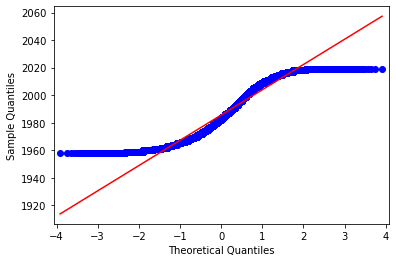

<IPython.core.display.Javascript object>

In [51]:
qqplot(top_songs["year"], line="s")
plt.show()

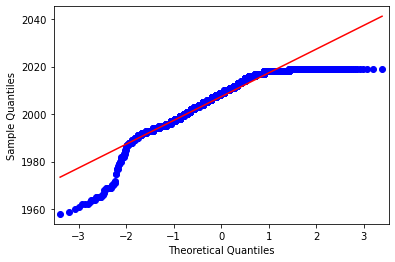

<IPython.core.display.Javascript object>

In [52]:
qqplot(rap_hiphop["year"], line="s")
plt.show()

# These plots show the data is not normalized, so I will perform the non-perimetric tests

## Kruskal Wallis - Explicit vs not explicit by year

In [53]:
_, p = stats.kruskal(
    top_expl["year"],
    top_not_expl["year"],
    rap_hiphop_expl["year"],
    rap_hiphop_not_expl["year"],
)
p

0.0

<IPython.core.display.Javascript object>

In [54]:
_, p1 = stats.mannwhitneyu(top_expl["year"], top_not_expl["year"])
_, p2 = stats.mannwhitneyu(top_expl["year"], rap_hiphop_expl["year"])
_, p3 = stats.mannwhitneyu(top_expl["year"], rap_hiphop_not_expl["year"])

_, p4 = stats.mannwhitneyu(top_not_expl["year"], rap_hiphop_expl["year"])
_, p5 = stats.mannwhitneyu(top_not_expl["year"], rap_hiphop_not_expl["year"])
_, p6 = stats.mannwhitneyu(rap_hiphop_expl["year"], rap_hiphop_not_expl["year"])


p_values = [p1, p2, p3, p4, p5, p6]
reject, corr_p, sidak, bonf = multipletests(p_values, alpha=0.05)

<IPython.core.display.Javascript object>

In [55]:
reject

array([ True, False,  True,  True,  True,  True])

<IPython.core.display.Javascript object>

In [56]:
corr_p

array([0.        , 0.06343273, 0.        , 0.        , 0.        ,
       0.        ])

<IPython.core.display.Javascript object>

In [57]:
sidak

0.008512444610847103

<IPython.core.display.Javascript object>

In [58]:
bonf

0.008333333333333333

<IPython.core.display.Javascript object>

# Conclusions:
## 1)
* There were very few 'explicit' songs before 1990
* Rap and hip-hop became popular right after the PMRC was formed in 1985
* Rap has many more explicit songs than not explicit songs

## 2)
* There is a significant difference in mean rank between the popularity of pop songs and rap/hip-hop songs
* There is a significant difference in mean rank between the popularity of rap/hip-hop songs and metal songs

## 3)
* There is a significant difference in mean rank between the popularity of explicit songs and non-explicit songs
* There is a significant difference in mean rank between the popularity of explicit rap songs and all non-explicit songs